In [2]:
import numpy as np
import torch
import sklearn
from sklearn.model_selection import train_test_split
from time import time
import matplotlib.pyplot as plt
from keras.datasets import cifar10
import torchvision
import torchvision.transforms as transforms

### Cifar10 dataset classification with CNN

In [ ]:
class Cifar10Classifier(torch.nn.Module):

    def __init__(self):
        super(Cifar10Classifier, self).__init__()

        self.features = torch.nn.Sequential(                                                        # inp: B 3 32 32
            torch.nn.BatchNorm2d(num_features=3),
            torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),    # B 64 32 32
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),   # B 64 32 32
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0),                                 # B 64 16 16
            torch.nn.Dropout2d(0.2),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),  # B 128 16 16
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1), # B 128 16 16
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0),                                 # B 128 8 8
            torch.nn.Dropout2d(0.2),
            torch.nn.BatchNorm2d(num_features=128),
            torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1), # B 256 8 8
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1), # B 256 8 8
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0),                                 # B 256 4 4
            torch.nn.Dropout2d(0.2)
        )

        self.decider = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4 * 4 * 256, 128),                                                      # B 4 * 4 * 256
            torch.nn.ReLU(),
            torch.nn.Linear(128, 10)                                                                # B 10
        )

        self.log_prob_cal = torch.nn.LogSoftmax(dim=-1)

        self.optimizer = torch.optim.Adam(filter(
            lambda p: p.requires_grad, self.parameters()), 
            lr=0.001
        )

        self.batch_x_placeholder = torch.zeros(size=[1, 3, 32, 32], dtype=torch.float32, device=torch.device('cuda:0'))
        self.batch_y_placeholder = torch.zeros(size=[1], dtype=torch.long, device=torch.device('cuda:0'))
    
    def forward(self, b_x, b_y=None):
        conv_features = self.features(b_x)
        class_scores = self.decider(conv_features.flatten(1))
        log_probs = self.log_prob_cal(class_scores)
        loss = -1 * torch.mean(log_probs[torch.arange(b_x.shape[0]), b_y])
        decision = torch.argmax(log_probs, dim=-1)
        return decision, loss
    
    def _forward(self, X, y=None):
        # resize placeholder
        if len(X) != len(self.batch_x_placeholder):
            self.batch_x_placeholder.resize_([len(X), 3, 32, 32])
            self.batch_y_placeholder.resize_([len(X)])
        
        self.batch_x_placeholder.copy_(torch.Tensor(X))
        if y is not None:
            self.batch_y_placeholder.copy_(torch.Tensor(y.astype(int)))

        b_decision, b_loss = self(self.batch_x_placeholder, self.batch_y_placeholder)

        if y is None:
            return b_decision
        return b_decision, b_loss
    
    def train_epoch(self, X_train, y_train, batch_size=32):
        self.train()

        iters_per_epoch = int(np.ceil(1.0 * len(X_train) / batch_size))

        # shuffling
        indices = np.arange(len(X_train))

        epoch_loss = 0
        tps = 0

        # iterate over training set
        for iter in range(iters_per_epoch):
            batch_indices = indices[iter * batch_size: min(len(indices), (iter + 1) * batch_size)]

            # forward
            b_decision, b_loss = self._forward(X_train[batch_indices, :, :, :], y_train[batch_indices])
            b_decision = b_decision.cpu().numpy()

            epoch_loss += float(b_loss) / iters_per_epoch
            tps += np.sum(y_train[batch_indices].astype(int) == b_decision)

            b_loss.backward()

            self.optimizer.step()
            self.optimizer.zero_grad()
            
        epoch_train_accuracy = tps * 100.0 / len(X_train)

        return epoch_loss, epoch_train_accuracy
    
    def evaluate(self, X, y=None, batch_size=32):
        with torch.no_grad():
            self.eval()

            iters_per_epoch = int(np.ceil(1.0 * len(X) / batch_size))

            indices = np.arange(len(X))

            predictions = []
            loss = 0
            tps = 0

            for iter in range(iters_per_epoch):
                batch_indices = indices[iter * batch_size: min(len(indices), (iter + 1) * batch_size)]

                if y is None:
                    b_decision = self._forward(X[batch_indices, :, :, :])
                else:
                    b_decision, b_loss = self._forward(X[batch_indices, :, :, :], y[batch_indices])

                b_decision = b_decision.cpu().numpy()

                if y is not None:
                    loss += float(b_loss) / iters_per_epoch
                    tps += np.sum(y[batch_indices].astype(int) == b_decision)
                else:
                    predictions.append(b_decision)

            if y is not None:
                accuracy = tps * 100.0 / len(X)
                return loss, accuracy
            
            return np.concatenate(predictions)

    def fit(self, X_train, y_train, epochs, batch_size):
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

        train_loss = np.zeros((epochs,))
        val_loss = np.zeros((epochs,))
        train_acc = np.zeros((epochs,))
        val_acc = np.zeros((epochs,))

        val_iters_per_epoch = int(np.ceil(1.0 * len(X_val) / batch_size))

        for e in range(epochs):
            t_start = time()

            # train over dataset
            epoch_train_loss, epoch_train_accuracy = self.train_epoch(X_train, y_train, batch_size)
            train_loss[e] = epoch_train_loss
            train_acc[e] = epoch_train_accuracy

            # validating over validation set
            epoch_val_loss, epoch_val_accuracy = self.evaluate(X_val, y_val, batch_size)
            val_loss[e] = epoch_val_loss
            val_acc[e] = epoch_val_accuracy

            #saving model
            torch.save({
                    'epoch': e,
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'model_state_dict': self.state_dict(),
                    'epoch_train_loss': epoch_train_loss,
                    'epoch_train_accuracy': epoch_train_accuracy,
                    'epoch_val_loss': epoch_val_loss,
                    'epoch_val_accuracy': epoch_val_accuracy
                }, f'epoch_{e}_state.pt')

            print(f'Epoch {e} finished in {time() - t_start:.2f}s. loss: {epoch_train_loss:.4f} - acc: {epoch_train_accuracy:.2f} - val loss: {epoch_val_loss:.4f} - val acc: {epoch_val_accuracy:.2f}')
        
        return train_loss, val_loss, train_acc, val_acc

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [3]:
X_train = np.transpose(X_train, axes=(0, 3, 1, 2))
X_train.shape

(50000, 3, 32, 32)

In [4]:
X_test = np.transpose(X_test, axes=(0, 3, 1, 2))
X_test.shape

(10000, 3, 32, 32)

In [5]:
y_train = y_train.reshape((50000,))
y_train.shape

(50000,)

In [6]:
y_test = y_test.reshape((10000,))
y_test.shape

(10000,)

In [ ]:
batch_size = 32
epochs = 40

In [ ]:
model = Cifar10Classifier()
model = model.cuda()

In [ ]:
train_loss, val_loss, train_acc, val_acc = model.fit(X_train, y_train, epochs, batch_size)

Epoch 0 finished in 34.93s. loss: 1.5773 - acc: 41.84 - val loss: 1.1615 - val acc: 57.61
Epoch 1 finished in 34.52s. loss: 1.1958 - acc: 56.87 - val loss: 1.0325 - val acc: 62.59
Epoch 2 finished in 34.59s. loss: 1.0243 - acc: 63.77 - val loss: 0.8548 - val acc: 69.78
Epoch 3 finished in 34.98s. loss: 0.9212 - acc: 67.70 - val loss: 0.7771 - val acc: 72.33
Epoch 4 finished in 34.92s. loss: 0.8306 - acc: 71.25 - val loss: 0.7078 - val acc: 74.84
Epoch 5 finished in 34.94s. loss: 0.7710 - acc: 73.25 - val loss: 0.6946 - val acc: 75.12
Epoch 6 finished in 34.87s. loss: 0.7215 - acc: 74.99 - val loss: 0.6540 - val acc: 77.11
Epoch 7 finished in 34.84s. loss: 0.6755 - acc: 76.59 - val loss: 0.6369 - val acc: 77.80
Epoch 8 finished in 34.91s. loss: 0.6420 - acc: 77.84 - val loss: 0.6056 - val acc: 79.03
Epoch 9 finished in 34.95s. loss: 0.6054 - acc: 79.24 - val loss: 0.5928 - val acc: 79.73
Epoch 10 finished in 34.89s. loss: 0.5791 - acc: 80.23 - val loss: 0.5894 - val acc: 79.86
Epoch 11 

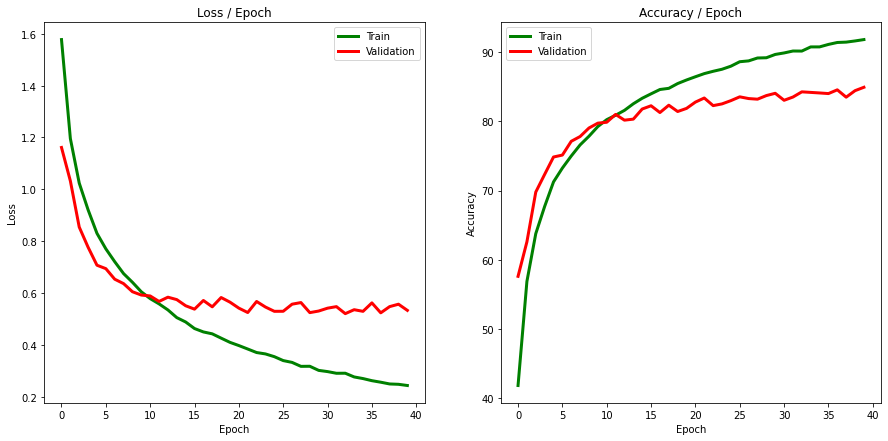

In [ ]:
fig = plt.figure(figsize=(15, 7))

# loss
ax = fig.add_subplot(121)
ax.set_title('Loss / Epoch')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_aspect('auto')

plt.plot(train_loss, label='Train', color='green', linewidth=3)
plt.plot(val_loss, label='Validation', color='red', linewidth=3)


plt.legend()

# acc
ax = fig.add_subplot(122)
ax.set_title('Accuracy / Epoch')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_aspect('auto')

plt.plot(train_acc, label='Train', color='green', linewidth=3)
plt.plot(val_acc, label='Validation', color='red', linewidth=3)


plt.legend()

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size)
print(f'Test loss: {test_loss:.4f} - Accuracy: {test_accuracy:.2f}')

Test loss: 0.5782 - Accuracy: 84.32


In [44]:
def draw(images, texts, columns=1, rows=1):
    fig = plt.figure(figsize=(2 * columns, 2 * rows))

    for i in range(columns * rows):
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.set_title(texts[i])
        ax.set_aspect('equal')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(images[i])

    cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.set_frame_on(False)
    plt.show()

In [ ]:
predictions = model.evaluate(X_test, batch_size=batch_size)
predictions.shape

(10000,)

In [31]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Some right predictions:

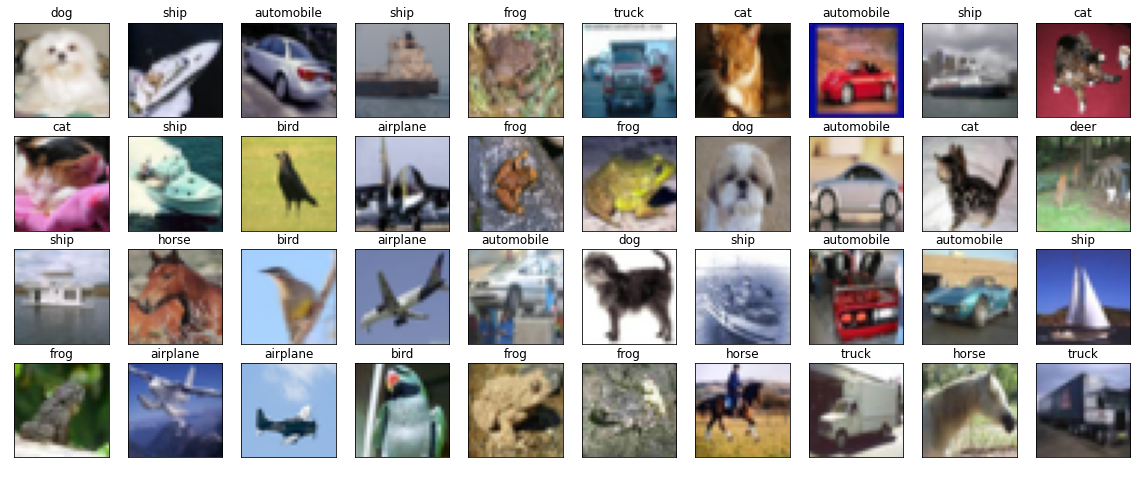

In [ ]:
right_images = X_test[predictions == y_test]
right_labels = predictions[predictions == y_test]
right_indices = np.random.choice(np.arange(len(right_images)), size=40)

images = right_images[right_indices]
label_predictions = right_labels[right_indices]
texts = [f'{labels[label_predictions[i]]}' for i in range(len(right_indices))]

draw(images, texts, 10, 4)

Some wrong predictions:

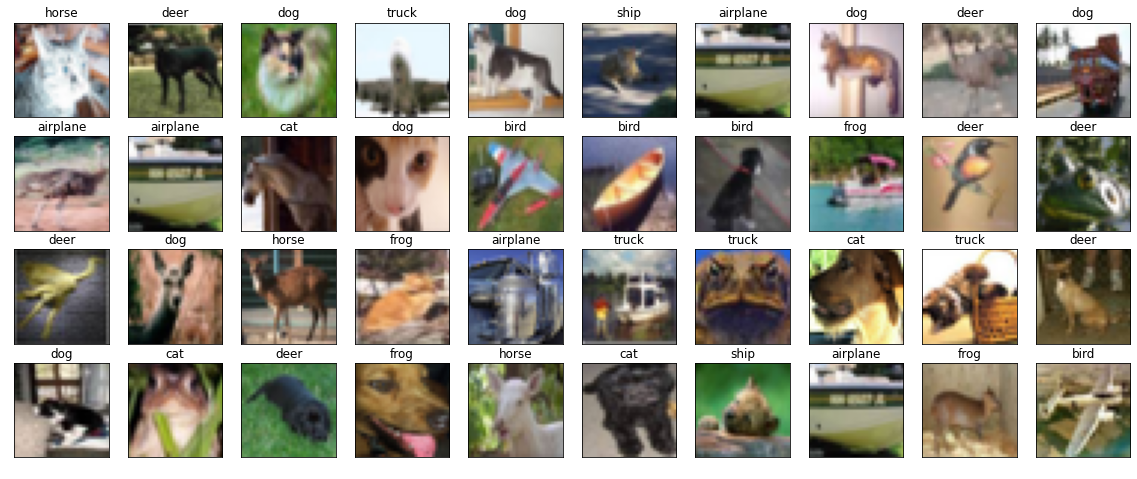

In [ ]:
wrong_images = X_test[predictions != y_test]
wrong_labels = predictions[predictions != y_test]
wrong_indices = np.random.choice(np.arange(len(wrong_images)), size=40)

images = wrong_images[wrong_indices]
wrong_label_predictions = wrong_labels[wrong_indices]
texts = [f'{labels[wrong_label_predictions[i]]}' for i in range(len(wrong_indices))]

draw(images, texts, 10, 4)

### Manual Resnet

In [52]:
class ResnetBlock(torch.nn.Module):

    def __init__(self, in_channels, out_channels, first_stride, downsample=None):
        super(ResnetBlock, self).__init__()
        
        # in: B C1 A A
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=first_stride, padding=1, bias=False)  # B C2  (A - 1) / S + 1     (A - 1) / S + 1
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.ReLU(inplace=True)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)                        # B C2  (A - 1) / S + 1     (A - 1) / S + 1
        self.bn2 = torch.nn.BatchNorm2d(out_channels)
        self.do = torch.nn.Dropout2d(0.2)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.do(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [153]:
class Cifar10Resnet(torch.nn.Module):

    def __init__(self):
        super(Cifar10Resnet, self).__init__()

        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),     # B 32  32  32
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)          # B 32  16  16
        )

        self.layer1 = self.layer2 = torch.nn.Sequential(
            ResnetBlock(32, 32, 1),                                         # B 32  16  16
            ResnetBlock(32, 32, 1)                                          # B 32  16  16
        )

        self.layer2 = torch.nn.Sequential(
            ResnetBlock(32, 32, 1),                                         # B 32  16  16
            ResnetBlock(32, 64, 2, downsample=torch.nn.Sequential(          # B 64  8   8
                torch.nn.Conv2d(32, 64, kernel_size=1, stride=2, padding=0),
                torch.nn.BatchNorm2d(64)
            ))
        )

        self.layer3 = torch.nn.Sequential(
            ResnetBlock(64, 64, 1),                                         # B 64  8   8
            ResnetBlock(64, 128, 2, downsample=torch.nn.Sequential(         # B 128 4   4
                torch.nn.Conv2d(64, 128, kernel_size=1, stride=2, padding=0),
                torch.nn.BatchNorm2d(128)
            ))
        )

        self.avgpool = torch.nn.AdaptiveAvgPool2d(output_size=1)            # B 128 1

        self.fc = torch.nn.Sequential(
            torch.nn.Dropout(0.6),
            torch.nn.Linear(128, 1024),                                      # B 4096
            torch.nn.ReLU(),
            torch.nn.Dropout(0.6),
            torch.nn.Linear(1024, 10),                                      # B 10
            torch.nn.LogSoftmax(dim=-1)
        )

        self.optimizer = torch.optim.Adam(filter(
            lambda p: p.requires_grad, self.parameters()), 
            lr=1e-3
        )

        self.batch_x_placeholder = torch.zeros(size=[1, 3, 32, 32], dtype=torch.float32, device=torch.device('cuda:0'))
        self.batch_y_placeholder = torch.zeros(size=[1], dtype=torch.long, device=torch.device('cuda:0'))
    
    def forward(self, b_x, b_y=None):
        
        out = self.conv1(b_x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = self.fc(out.flatten(1))

        loss = -1 * torch.mean(out[torch.arange(b_x.shape[0]), b_y])
        decision = torch.argmax(out, dim=-1)
        return decision, loss
    
    def _forward(self, X, y=None):
        # resize placeholder
        if len(X) != len(self.batch_x_placeholder):
            self.batch_x_placeholder.resize_([len(X), 3, 32, 32])
            self.batch_y_placeholder.resize_([len(X)])
        
        self.batch_x_placeholder.copy_(torch.Tensor(X))
        if y is not None:
            self.batch_y_placeholder.copy_(torch.Tensor(y.astype(int)))

        b_decision, b_loss = self(self.batch_x_placeholder, self.batch_y_placeholder)

        if y is None:
            return b_decision
        return b_decision, b_loss
    
    def train_epoch(self, X_train, y_train, batch_size=32):
        self.train()

        iters_per_epoch = int(np.ceil(1.0 * len(X_train) / batch_size))

        # shuffling
        indices = np.arange(len(X_train))
        np.random.shuffle(indices)

        epoch_loss = 0
        corrects = 0

        # iterate over training set
        for iter in range(iters_per_epoch):
            batch_indices = indices[iter * batch_size: min(len(indices), (iter + 1) * batch_size)]

            # forward
            b_decision, b_loss = self._forward(X_train[batch_indices, :, :, :], y_train[batch_indices])
            b_decision = b_decision.cpu().numpy()

            epoch_loss += float(b_loss) / iters_per_epoch
            corrects += np.sum(y_train[batch_indices].astype(int) == b_decision)

            if iter % 50 == 0:
                print(f'    Iteration {iter:3d}. batch loss: {float(b_loss):.4e}')

            b_loss.backward()

            self.optimizer.step()
            self.optimizer.zero_grad()
            
        epoch_train_accuracy = corrects * 100.0 / len(X_train)

        return epoch_loss, epoch_train_accuracy
    
    def evaluate(self, X, y=None, batch_size=32):
        with torch.no_grad():
            self.eval()

            iters_per_epoch = int(np.ceil(1.0 * len(X) / batch_size))

            indices = np.arange(len(X))

            predictions = []
            loss = 0
            corrects = 0

            for iter in range(iters_per_epoch):
                batch_indices = indices[iter * batch_size: min(len(indices), (iter + 1) * batch_size)]

                if y is None:
                    b_decision = self._forward(X[batch_indices, :, :, :])
                else:
                    b_decision, b_loss = self._forward(X[batch_indices, :, :, :], y[batch_indices])

                b_decision = b_decision.cpu().numpy()

                if y is not None:
                    loss += float(b_loss) / iters_per_epoch
                    corrects += np.sum(y[batch_indices].astype(int) == b_decision)
                else:
                    predictions.append(b_decision)

            if y is not None:
                accuracy = corrects * 100.0 / len(X)
                return loss, accuracy
            
            return np.concatenate(predictions)

    def fit(self, X_train, y_train, epochs, batch_size):
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

        train_loss = np.zeros((epochs,))
        val_loss = np.zeros((epochs,))
        train_acc = np.zeros((epochs,))
        val_acc = np.zeros((epochs,))

        val_iters_per_epoch = int(np.ceil(1.0 * len(X_val) / batch_size))

        for e in range(epochs):
            t_start = time()

            # train over dataset
            epoch_train_loss, epoch_train_accuracy = self.train_epoch(X_train, y_train, batch_size)
            train_loss[e] = epoch_train_loss
            train_acc[e] = epoch_train_accuracy

            # validating over validation set
            epoch_val_loss, epoch_val_accuracy = self.evaluate(X_val, y_val, batch_size)
            val_loss[e] = epoch_val_loss
            val_acc[e] = epoch_val_accuracy

            #saving model
            torch.save({
                    'epoch': e,
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'model_state_dict': self.state_dict(),
                    'epoch_train_loss': epoch_train_loss,
                    'epoch_train_accuracy': epoch_train_accuracy,
                    'epoch_val_loss': epoch_val_loss,
                    'epoch_val_accuracy': epoch_val_accuracy
                }, f'epoch_{e}_state.pt')

            print(f'Epoch {e} finished in {time() - t_start:.2f}s. loss: {epoch_train_loss:.4f} - acc: {epoch_train_accuracy:.2f} - val loss: {epoch_val_loss:.4f} - val acc: {epoch_val_accuracy:.2f}')
        
        return train_loss, val_loss, train_acc, val_acc

In [154]:
resnet = Cifar10Resnet().cuda()

In [155]:
batch_size = 128
epochs = 30

In [156]:
train_loss, val_loss, train_acc, val_acc = resnet.fit(X_train, y_train, epochs, batch_size)

    Iteration   0. batch loss: 2.3449e+00
    Iteration  50. batch loss: 1.8607e+00
    Iteration 100. batch loss: 2.0364e+00
    Iteration 150. batch loss: 1.6935e+00
    Iteration 200. batch loss: 1.7135e+00
    Iteration 250. batch loss: 1.6505e+00
    Iteration 300. batch loss: 1.4913e+00
Epoch 0 finished in 7.43s. loss: 1.7889 - acc: 30.84 - val loss: 1.8972 - val acc: 32.04
    Iteration   0. batch loss: 1.6875e+00
    Iteration  50. batch loss: 1.6401e+00
    Iteration 100. batch loss: 1.4756e+00
    Iteration 150. batch loss: 1.4780e+00
    Iteration 200. batch loss: 1.4257e+00
    Iteration 250. batch loss: 1.4796e+00
    Iteration 300. batch loss: 1.5629e+00
Epoch 1 finished in 7.47s. loss: 1.4892 - acc: 44.04 - val loss: 1.6461 - val acc: 38.31
    Iteration   0. batch loss: 1.5049e+00
    Iteration  50. batch loss: 1.4520e+00
    Iteration 100. batch loss: 1.3205e+00
    Iteration 150. batch loss: 1.2428e+00
    Iteration 200. batch loss: 1.2488e+00
    Iteration 250. batch

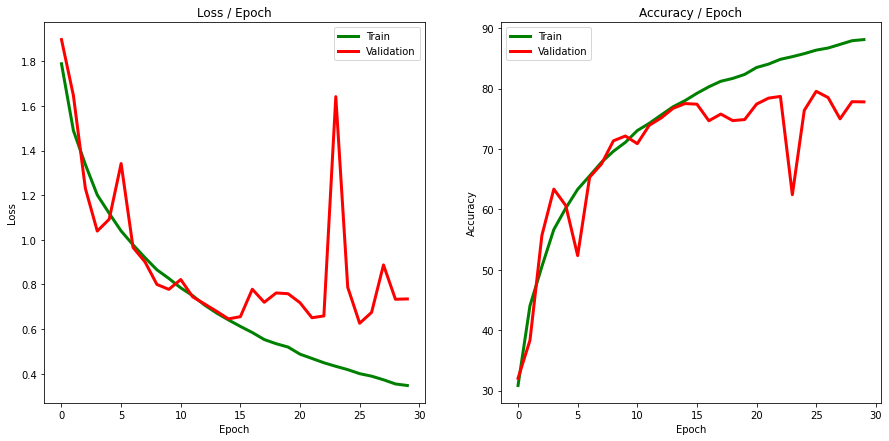

In [157]:
fig = plt.figure(figsize=(15, 7))

# loss
ax = fig.add_subplot(121)
ax.set_title('Loss / Epoch')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_aspect('auto')

plt.plot(train_loss, label='Train', color='green', linewidth=3)
plt.plot(val_loss, label='Validation', color='red', linewidth=3)


plt.legend()

# acc
ax = fig.add_subplot(122)
ax.set_title('Accuracy / Epoch')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_aspect('auto')

plt.plot(train_acc, label='Train', color='green', linewidth=3)
plt.plot(val_acc, label='Validation', color='red', linewidth=3)


plt.legend()

In [77]:
test_loss, test_acc = resnet.evaluate(X_test, y_test, batch_size)

In [78]:
test_loss

0.9392898754228517

In [79]:
test_acc

73.86

### Pretrained ResNet

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10, resample=False),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [4]:
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=128, shuffle=False, num_workers=2)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
def make_no_grad(module):
    for param in module.parameters():
        param.requires_grad_(False)

In [18]:
def create_resnet18():
    resnet = torchvision.models.resnet18(pretrained=True, progress=True)
    resnet.fc = torch.nn.Sequential(
        torch.nn.Dropout(0.5),
        torch.nn.Linear(512, 10),
        torch.nn.LogSoftmax(dim=-1)
    )

    make_no_grad(resnet.conv1)
    make_no_grad(resnet.layer1)
    make_no_grad(resnet.layer2)

    def forward_impl(x):
        with torch.no_grad():
            x = resnet.conv1(x)
            x = resnet.bn1(x)
            x = resnet.relu(x)
            x = resnet.maxpool(x)

            x = resnet.layer1(x)
            x = resnet.layer2(x)
        x = resnet.layer3(x)
        x = resnet.layer4(x)

        x = resnet.avgpool(x)
        x = resnet.fc(x.flatten(1))

        return x
    
    resnet.forward = forward_impl

    return torch.nn.DataParallel(resnet)

In [22]:
class Trainer(torch.nn.Module):

    def __init__(self, net, lr=0.001):
        super(Trainer, self).__init__()

        self.net = net

        self.batch_x_placeholder = torch.zeros(size=[1, 3, 224, 224], dtype=torch.float32, device=torch.device('cuda:0'))
        self.batch_y_placeholder = torch.zeros(size=[1], dtype=torch.long, device=torch.device('cuda:0'))

        self.optimizer = torch.optim.Adam(filter(
            lambda p: p.requires_grad, self.parameters()), 
            lr=lr
        )
    
    def forward(self, b_x, b_y=None):
        out = self.net(b_x)
        loss = -1 * torch.mean(out[torch.arange(b_x.shape[0]), b_y])
        decision = torch.argmax(out, dim=-1)
        return decision, loss

    def _forward(self, X, y=None):
        # resize placeholder
        if len(X) != len(self.batch_x_placeholder):
            self.batch_x_placeholder.resize_([len(X), 3, 224, 224])
            self.batch_y_placeholder.resize_([len(X)])
        
        self.batch_x_placeholder.copy_(X)
        if y is not None:
            self.batch_y_placeholder.copy_(y)

        b_decision, b_loss = self(self.batch_x_placeholder, self.batch_y_placeholder)

        if y is None:
            return b_decision
        return b_decision, b_loss
    
    def train_epoch(self, trainset, batch_size=32):
        self.train()

        epoch_loss = 0
        corrects = 0
        total = 0

        iter = 1

        # iterate over training set
        for b_x, b_y in trainset:

            # forward
            b_decision, b_loss = self._forward(b_x, b_y)
            b_decision = b_decision.cpu().numpy()

            epoch_loss += float(b_loss)
            corrects += np.sum(b_y.cpu().numpy() == b_decision)
            total += len(b_y)

            if iter % 50 == 0:
                print(f'    [Train] Iteration {iter:3d}. loss: {epoch_loss / iter:.4e} - accuracy: {corrects * 100.0 / total:.2f}')

            b_loss.backward()

            self.optimizer.step()
            self.optimizer.zero_grad()
            
            iter += 1
            
        epoch_train_accuracy = corrects * 100.0 / total
        epoch_loss /= (iter - 1)

        return epoch_loss, epoch_train_accuracy
    
    def evaluate(self, testset):
        with torch.no_grad():
            self.eval()

            predictions = []
            loss = 0
            corrects = 0
            total = 0

            iter = 1
           
            for b_x, b_y in testset:

                b_decision, b_loss = self._forward(b_x, b_y)
                b_decision = b_decision.cpu().numpy()

                loss += float(b_loss)
                corrects += np.sum(b_y.cpu().numpy() == b_decision)
                total += len(b_y)
                predictions.append(b_decision)

                if iter % 50 == 0:
                    print(f'    [Test] Iteration {iter:3d}. loss: {loss / iter:.4e} - accuracy: {corrects * 100.0 / total:.2f}')


                iter += 1

            accuracy = corrects * 100.0 / total
            loss /= (iter - 1)

            return np.concatenate(predictions), loss, accuracy

    def fit(self, trainset, epochs):
        trainset, validationset = torch.utils.data.random_split(trainset, lengths=(int(len(trainset) * 0.8), int(len(trainset) * 0.2)))

        trainloader = torch.utils.data.DataLoader(
            trainset, batch_size=128, shuffle=True, num_workers=2)
        
        validationloader = torch.utils.data.DataLoader(
            validationset, batch_size=128, shuffle=False, num_workers=2)


        train_loss = np.zeros((epochs,))
        val_loss = np.zeros((epochs,))
        train_acc = np.zeros((epochs,))
        val_acc = np.zeros((epochs,))


        for e in range(epochs):
            t_start = time()

            # train over dataset
            epoch_train_loss, epoch_train_accuracy = self.train_epoch(trainloader)
            train_loss[e] = epoch_train_loss
            train_acc[e] = epoch_train_accuracy

            # validating over validation set
            _, epoch_val_loss, epoch_val_accuracy = self.evaluate(validationloader)
            val_loss[e] = epoch_val_loss
            val_acc[e] = epoch_val_accuracy

            #saving model
            torch.save({
                    'epoch': e,
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'model_state_dict': self.state_dict(),
                    'epoch_train_loss': epoch_train_loss,
                    'epoch_train_accuracy': epoch_train_accuracy,
                    'epoch_val_loss': epoch_val_loss,
                    'epoch_val_accuracy': epoch_val_accuracy
                }, f'epoch_{e}_state.pt')

            print(f'Epoch {e} finished in {time() - t_start:.2f}s. loss: {epoch_train_loss:.4f} - acc: {epoch_train_accuracy:.2f} - val loss: {epoch_val_loss:.4f} - val acc: {epoch_val_accuracy:.2f}')
        
        return train_loss, val_loss, train_acc, val_acc

In [23]:
resnet = Trainer(create_resnet18()).cuda()

In [24]:
epochs = 30

In [25]:
train_loss, val_loss, train_acc, val_acc = resnet.fit(trainset, epochs)

    [Train] Iteration  50. loss: 9.8316e-01 - accuracy: 65.28
    [Train] Iteration 100. loss: 8.3044e-01 - accuracy: 71.18
    [Train] Iteration 150. loss: 7.5682e-01 - accuracy: 73.83
    [Train] Iteration 200. loss: 7.0194e-01 - accuracy: 75.84
    [Train] Iteration 250. loss: 6.6525e-01 - accuracy: 77.12
    [Train] Iteration 300. loss: 6.3862e-01 - accuracy: 78.20
    [Test] Iteration  50. loss: 4.5589e-01 - accuracy: 84.22
Epoch 0 finished in 101.14s. loss: 0.6336 - acc: 78.38 - val loss: 0.4480 - val acc: 84.45
    [Train] Iteration  50. loss: 4.1382e-01 - accuracy: 86.25
    [Train] Iteration 100. loss: 4.2596e-01 - accuracy: 85.54
    [Train] Iteration 150. loss: 4.2224e-01 - accuracy: 85.73
    [Train] Iteration 200. loss: 4.1700e-01 - accuracy: 85.99
    [Train] Iteration 250. loss: 4.1395e-01 - accuracy: 86.05
    [Train] Iteration 300. loss: 4.0876e-01 - accuracy: 86.14
    [Test] Iteration  50. loss: 3.8036e-01 - accuracy: 87.02
Epoch 1 finished in 101.43s. loss: 0.4080 -

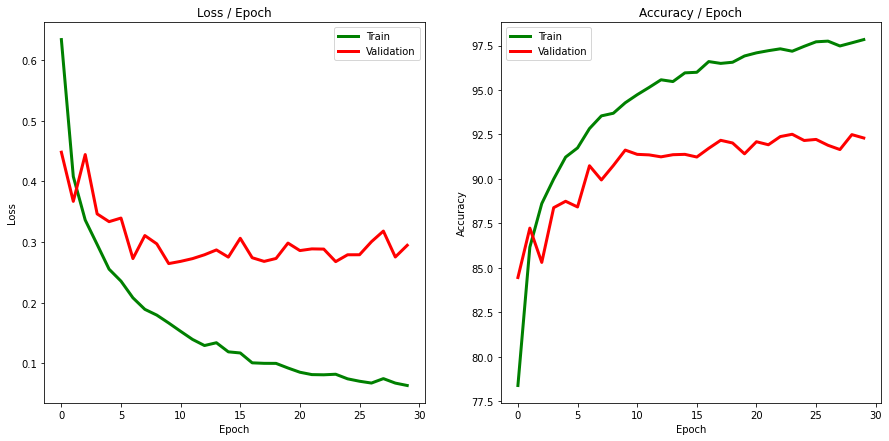

In [26]:
fig = plt.figure(figsize=(15, 7))

# loss
ax = fig.add_subplot(121)
ax.set_title('Loss / Epoch')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_aspect('auto')

plt.plot(train_loss, label='Train', color='green', linewidth=3)
plt.plot(val_loss, label='Validation', color='red', linewidth=3)


plt.legend()

# acc
ax = fig.add_subplot(122)
ax.set_title('Accuracy / Epoch')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_aspect('auto')

plt.plot(train_acc, label='Train', color='green', linewidth=3)
plt.plot(val_acc, label='Validation', color='red', linewidth=3)


plt.legend()

In [29]:
predictions, test_loss, test_accuracy = resnet.evaluate(testloader)

    [Test] Iteration  50. loss: 3.3316e-01 - accuracy: 93.11


In [30]:
test_accuracy

93.33

Right classifications:

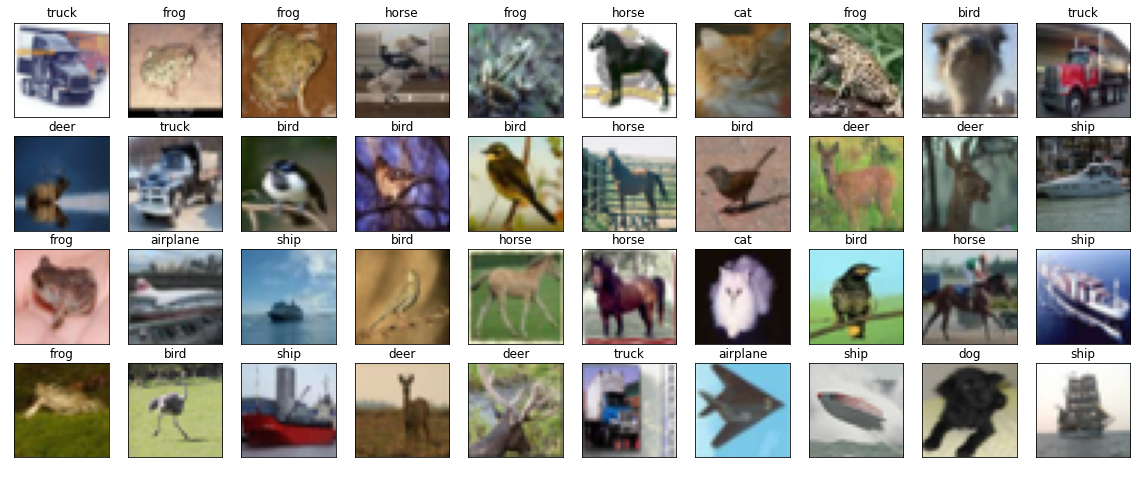

In [48]:
right_indices = predictions == np.array(testset.targets)
right_images = testset.data[right_indices]
right_labels = predictions[right_indices]
choosen_indices = np.random.choice(np.arange(len(right_images)), size=40)

images = right_images[choosen_indices]
label_predictions = right_labels[choosen_indices]
texts = [f'{labels[label_predictions[i]]}' for i in range(len(choosen_indices))]

draw(images, texts, 10, 4)

Wrong classifications:

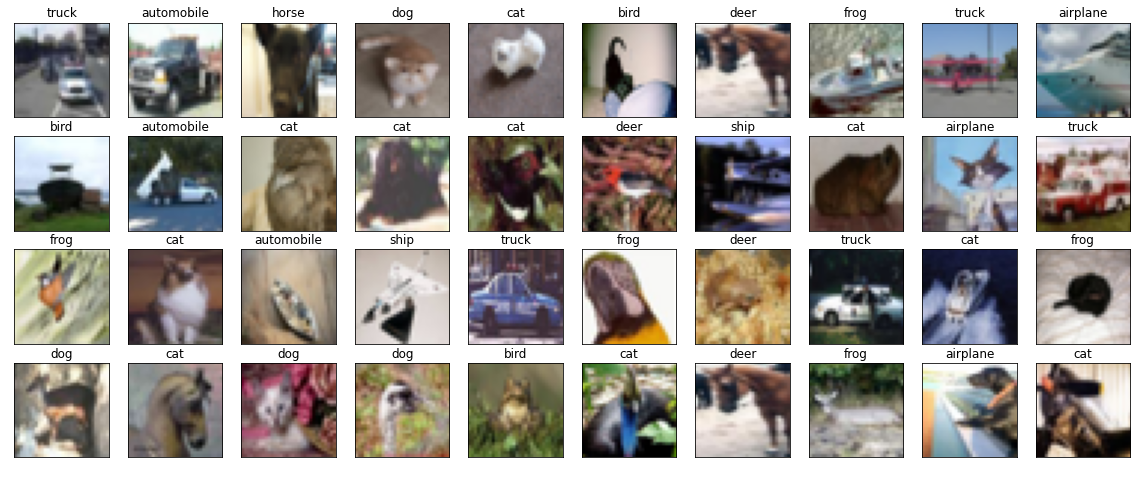

In [51]:
wrong_indices = predictions != np.array(testset.targets)

wrong_images = testset.data[wrong_indices]
wrong_labels = predictions[wrong_indices]
choosen_indices = np.random.choice(np.arange(len(wrong_images)), size=40)

images = wrong_images[choosen_indices]
wrong_label_predictions = wrong_labels[choosen_indices]
texts = [f'{labels[wrong_label_predictions[i]]}' for i in range(len(choosen_indices))]

draw(images, texts, 10, 4)

### Pretrained VGG-16

In [53]:
def create_vgg16():
    vgg16 = torchvision.models.vgg16_bn(pretrained=True, progress=True)
    vgg16.classifier = torch.nn.Sequential(
        torch.nn.Linear(25088, 4096),
        torch.nn.ReLU(inplace=True),
        torch.nn.Dropout(0.5),
        torch.nn.Linear(4096, 4096),
        torch.nn.ReLU(inplace=True),
        torch.nn.Dropout(0.5),
        torch.nn.Linear(4096, 10),
        torch.nn.LogSoftmax(dim=-1)
    )

    make_no_grad(vgg16.features)

    def forward_impl(x):
        with torch.no_grad():
            x = vgg16.features(x)

        x = vgg16.avgpool(x)
        x = vgg16.classifier(x.flatten(1))

        return x
    
    vgg16.forward = forward_impl

    return torch.nn.DataParallel(vgg16)

In [54]:
vgg16 = Trainer(create_vgg16()).cuda()

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


In [55]:
epochs = 30

In [ ]:
train_loss, val_loss, train_acc, val_acc = vgg16.fit(trainset, epochs)

    [Train] Iteration  50. loss: 1.8183e+00 - accuracy: 39.44
    [Train] Iteration 100. loss: 1.4887e+00 - accuracy: 48.85
    [Train] Iteration 150. loss: 1.3366e+00 - accuracy: 53.96
